# **Support vector machine sigmoid kernel (SVM with sigmoid)**

## **1. Import necessary libraries**

In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.metrics import accuracy_score
from sklearn import preprocessing
from sklearn import utils
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.pipeline import Pipeline, make_pipeline

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import warnings

warnings.filterwarnings('ignore')

## **2. Insert and preprocess data**

### **2.1. Load data**
Load our data from path `../Data/processed_data.csv`.

In [3]:
# Load our data from path `../Data/processed_data.csv`
courses_df = pd.read_csv('../Data/processed_data.csv', sep=',',engine='python', encoding='utf-8')
courses_df.sample(5)

,name,general,specify,enrollment,language,rating,level,duration,instructor,instructor_rate,offered by
653,Blockchain Transformations of Financial Services,Computer Science,Computer Security and Networks,6499,English,4.7,Beginner,15,"Don Tapscott, Alex Tapscott",4.7,INSEAD
4243,Prepare for the EMT Certification Test,Health,Patient Care,10274,English,4.7,Beginner,10,"Arthur Pliaconis, Whitney Barrett, MD, Kathrin...",4.9,University of Colorado System
2532,Entrepreneurship 3: Growth Strategies,Business,Entrepreneurship,45326,English,4.8,Beginner,8,"Kartik Hosanagar, David Hsu, Lori Rosenkopf, K...",4.7,University of Pennsylvania
1994,Habilidades de Excel para el negocio: Concepto...,Business,Business Essentials,47238,Spanish,4.9,Beginner,26,"Nicky Bull, Professor Yvonne Breyer, Dr Prasha...",4.9,Macquarie University
863,Chinese Politics Part 2 – China and the World,Social Sciences,Governance and Society,10568,English,4.7,Beginner,13,David Zweig,4.9,The Hong Kong University of Science and Techno...


### **2.2. Preprocess data**

- The `name` and `instructor` features needs to be removed because it is not useful in training the model.

In [4]:
data_ = courses_df.copy().drop(columns=['name', 'instructor'])
data_.sample(5)

,general,specify,enrollment,language,rating,level,duration,instructor_rate,offered by
1245,Personal Development,Personal Development,7427,Arabic,4.9,Intermediate,5,4.8,Alfaisal University | KLD
2156,Physical Science and Engineering,Mechanical Engineering,48569,English,4.8,Other,19,4.7,University of Minnesota
2387,Business,Leadership and Management,4181,Portuguese (Brazilian),4.9,Beginner,22,5.0,Google
3107,Information Technology,Cloud Computing,15400,English,4.2,Beginner,1,4.3,Google Cloud
208,Data Science,Machine Learning,19320,English,4.5,Advanced,15,4.5,IBM


- Explore missing values in variables:
    + View summary of dataset.

In [5]:
data_.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5718 entries, 0 to 5717
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   general          5717 non-null   object 
 1   specify          5717 non-null   object 
 2   enrollment       5718 non-null   int64  
 3   language         5718 non-null   object 
 4   rating           5718 non-null   float64
 5   level            5718 non-null   object 
 6   duration         5718 non-null   int64  
 7   instructor_rate  5718 non-null   float64
 8   offered by       5703 non-null   object 
dtypes: float64(2), int64(2), object(5)
memory usage: 402.2+ KB


In [6]:
print('Number missing values in each column:\n',data_.isnull().sum())

Number missing values in each column:
 general             1
specify             1
enrollment          0
language            0
rating              0
level               0
duration            0
instructor_rate     0
offered by         15
dtype: int64


- Explore missing values in variables:
    + Drop rows with missing values: Because the number of missing values each variable is insignificant, we will remove rows containing missing data.

In [7]:
# Drop rows with missing values
data_.dropna(inplace=True)
print('Number missing values in each column:\n',data_.isnull().sum())

Number missing values in each column:
 general            0
specify            0
enrollment         0
language           0
rating             0
level              0
duration           0
instructor_rate    0
offered by         0
dtype: int64


## **3. Prepare for training model**

### **3.1. Define kind of features**

- Define selection and target features to prepare data for training model.

In [8]:
# Define selection and target features to prepare data for training model
target = ['rating']
specificities = list(set(data_.columns) - set(target))

- Define numerical and categorical features to transformer.

In [9]:
# Define numerical and categorical features
numeracy_ = list(set(specificities) - set(courses_df.select_dtypes(include=['object']).columns))
category_ = list(set(specificities) - set(courses_df.select_dtypes(exclude=['object']).columns))
print('Numerical features:', numeracy_)
print('Categorical features:', category_)

Numerical features: ['duration', 'enrollment', 'instructor_rate']
Categorical features: ['general', 'level', 'offered by', 'specify', 'language']


### **3.2. Split data**
Split data into 3 datasets: `Training dataset`, `Validation dataset` and `Testing dataset`. We’ll perform splitting on the following ratio 80-20.

In [10]:
# Define the constant variable random_state
random_state = 2112

# Select features and target variable
X = data_[specificities]
y = data_[target]

# Split data on the following ratio 80-20
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=random_state)

### **3.3. Initialize transformer**

In [11]:
# Create transformer for numerical and categorical features by using Pipeline
num_transformer = Pipeline(steps=[('scaler', StandardScaler())])
cat_transformer = Pipeline(steps=[('onehot', OneHotEncoder(sparse=False, handle_unknown='ignore'))])

# Create a preprocessor using ColumnTransformer
preprocessor = ColumnTransformer(transformers=[('num', num_transformer, numeracy_),
                                               ('cat', cat_transformer, category_)])

### **3.4. Search hyperparameter for available data fitting model**

In [12]:
# Use SVR for regression
pipe_svm = Pipeline([('preprocessor', preprocessor),
                      ('regressor', SVR())])

# Fine-tuning hyperparameters
param_kernel = ['linear', 'rbf', 'sigmoid', 'poly']
param_C = [0.01, 0.1, 1.0, 10.0]
param_gamma = [0.001, 0.01, 0.1, 1.0]
param_grid = [{'regressor__C': param_C,
               'regressor__kernel': param_kernel,
               'regressor__gamma': param_gamma}]

# Use a regression-specific scoring metric
reg_gs = GridSearchCV(
    estimator=pipe_svm,
    param_grid=param_grid,
    scoring="neg_mean_squared_error",
    return_train_score=True,
    cv=5)

reg_gs = reg_gs.fit(X_train, y_train)

In [15]:
print('[SVR: grid search]')
print('Validation MSE: %.6f' % -reg_gs.best_score_)  # Print as positive MSE # Common regression metric
print(reg_gs.best_params_)

[SVR: grid search]
Validation MSE: 0.033245
{'regressor__C': 10.0, 'regressor__gamma': 0.01, 'regressor__kernel': 'rbf'}


In [43]:
# Get scoring values of ref_gs
recording_df = pd.DataFrame({'kernel':np.ma.getdata(reg_gs.cv_results_['param_regressor__kernel']),
                             'C':np.ma.getdata(reg_gs.cv_results_['param_regressor__C']),
                             'gamma':np.ma.getdata(reg_gs.cv_results_['param_regressor__gamma']),
                             'mean_test':['{:f}'.format(item) for item in -reg_gs.cv_results_['mean_test_score'].round(6)],
                             'mean_train':['{:f}'.format(item) for item in -reg_gs.cv_results_['mean_train_score'].round(6)],
                             'ranking':reg_gs.cv_results_['rank_test_score']},
                            index=reg_gs.cv_results_['params'])\
                                .sort_values(by=['kernel', 'C', 'gamma'], ascending=[True, True, True])
recording_df.head(20)

,kernel,C,gamma,mean_test,mean_train,ranking
"{'regressor__C': 0.01, 'regressor__gamma': 0.001, 'regressor__kernel': 'linear'}",linear,0.01,0.001,0.034336,0.032880,10
"{'regressor__C': 0.01, 'regressor__gamma': 0.01, 'regressor__kernel': 'linear'}",linear,0.01,0.01,0.034336,0.032880,10
"{'regressor__C': 0.01, 'regressor__gamma': 0.1, 'regressor__kernel': 'linear'}",linear,0.01,0.1,0.034336,0.032880,10
"{'regressor__C': 0.01, 'regressor__gamma': 1.0, 'regressor__kernel': 'linear'}",linear,0.01,1.0,0.034336,0.032880,10
"{'regressor__C': 0.1, 'regressor__gamma': 0.001, 'regressor__kernel': 'linear'}",linear,0.1,0.001,0.034180,0.030559,4
"{'regressor__C': 0.1, 'regressor__gamma': 0.01, 'regressor__kernel': 'linear'}",linear,0.1,0.01,0.034180,0.030559,4
"{'regressor__C': 0.1, 'regressor__gamma': 0.1, 'regressor__kernel': 'linear'}",linear,0.1,0.1,0.034180,0.030559,4
"{'regressor__C': 0.1, 'regressor__gamma': 1.0, 'regressor__kernel': 'linear'}",linear,0.1,1.0,0.034180,0.030559,4
"{'regressor__C': 1.0, 'regressor__gamma': 0.001, 'regressor__kernel': 'linear'}",linear,1.0,0.001,0.034680,0.029107,14
"{'regressor__C': 1.0, 'regressor__gamma': 0.01, 'regressor__kernel': 'linear'}",linear,1.0,0.01,0.034680,0.029107,14


          0.001     0.010     0.100     1.000
0.01   0.034336  0.034336  0.034336  0.034336
0.10   0.034180  0.034180  0.034180  0.034180
1.00   0.034680  0.034680  0.034680  0.034680
10.00  0.034680  0.034680  0.034680  0.034680
          0.001     0.010     0.100     1.000
0.01   0.064499  0.063693  0.045041  0.061294
0.10   0.064492  0.058730  0.035833  0.158331
1.00   0.064422  0.056369  0.039317  0.679049
10.00  0.063693  0.045040  0.061286  1.915906
          0.001     0.010     0.100     1.000
0.01   0.057921  0.041694  0.042040  0.062305
0.10   0.039606  0.034881  0.034905  0.054090
1.00   0.034966  0.033384  0.034261  0.050765
10.00  0.033924  0.033245  0.040438  0.051997
          0.001     0.010         0.100           1.000
0.01   0.060990  0.044197      0.050574        2.502901
0.10   0.044121  0.035569      5.848550      243.098794
1.00   0.035606  0.046007    614.454651    24181.768396
10.00  0.034333  4.741948  62425.209079  2398409.947203


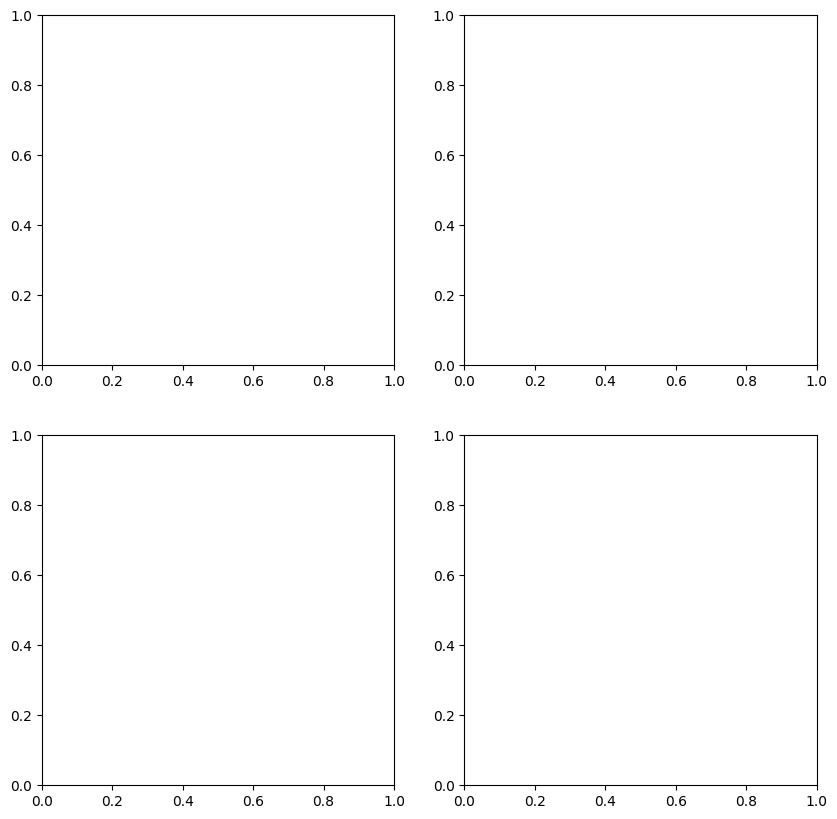

In [83]:
heatmap_df = recording_df.reset_index().drop(columns=['index', 'mean_train', 'ranking']).set_index(['kernel'])

# Set up the matplotlib figure
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))

# Plot heatmap each kernel
for index, kernel in enumerate(heatmap_df.index.unique()):
    ax = axes[index // 2, index % 2]
    data_plot = heatmap_df.loc[kernel].copy()\
        .reset_index().drop(columns=['kernel'])\
        .set_index(['C', 'gamma'])
    data_plot = data_plot['mean_test'].unstack('gamma').rename_axis(None, axis=1)
    data_plot.index.name = None
    # sns.heatmap(data_plot, ax=ax)
    print(data_plot)

# data_temp = heatmap_df.loc['linear'].copy().reset_index().drop(columns=['kernel']).set_index(['C', 'gamma'])
# data_temp['mean_test'].unstack('gamma').rename_axis(None, axis=1)

In [ ]:

# # Fit and transform the training data using the preprocessor
# pd.DataFrame(preprocessor.fit_transform(X_train, y_train))

# # # Transform the validation and test data using the preprocessor
# # X_val_preprocessed = preprocessor.transform(X_val)
# # X_test_preprocessed = preprocessor.transform(X_test)

array([0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
       0.01, 0.01, 0.01, 0.01, 0.01, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1,
       0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 1.0, 1.0, 1.0, 1.0,
       1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 10.0,
       10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0,
       10.0, 10.0, 10.0, 10.0], dtype=object)

In [ ]:
# Import data
data = np.loadtxt("data.csv", dtype=float, delimiter=",")

# Create figure
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection="3d")

# Plot data
ax.scatter(data[:, 0], data[:, 1], data[:, 2], c=data[:, 3])

# Set labels
ax.set_xlabel("C")
ax.set_ylabel("Gamma")
ax.set_zlabel("Kernel")
ax.set_title("Mean test score")

# Show figure
plt.show()


In [ ]:
# print("Grid scores on development set:")

# means = gs_spe.cv_results_['mean_test_score']
# stds = gs_spe.cv_results_['std_test_score']
# i = 0
# for mean, std, params in zip(means, stds, gs_spe.cv_results_['params']):
#     print("[%d]: %0.4f (+/-%0.03f) for %r"
#           % (i, -mean, std * 2, params))
#     i += 1

Grid scores on development set:
[0]: 0.0579 (+/-0.008) for {'regressor__C': 0.01, 'regressor__gamma': 0.001, 'regressor__kernel': 'rbf'}
[1]: 0.0610 (+/-0.008) for {'regressor__C': 0.01, 'regressor__gamma': 0.001, 'regressor__kernel': 'sigmoid'}
[2]: 0.0417 (+/-0.006) for {'regressor__C': 0.01, 'regressor__gamma': 0.01, 'regressor__kernel': 'rbf'}
[3]: 0.0442 (+/-0.005) for {'regressor__C': 0.01, 'regressor__gamma': 0.01, 'regressor__kernel': 'sigmoid'}
[4]: 0.0420 (+/-0.008) for {'regressor__C': 0.01, 'regressor__gamma': 0.1, 'regressor__kernel': 'rbf'}
[5]: 0.0506 (+/-0.007) for {'regressor__C': 0.01, 'regressor__gamma': 0.1, 'regressor__kernel': 'sigmoid'}
[6]: 0.0623 (+/-0.009) for {'regressor__C': 0.01, 'regressor__gamma': 1.0, 'regressor__kernel': 'rbf'}
[7]: 2.5029 (+/-0.381) for {'regressor__C': 0.01, 'regressor__gamma': 1.0, 'regressor__kernel': 'sigmoid'}
[8]: 0.0396 (+/-0.005) for {'regressor__C': 0.1, 'regressor__gamma': 0.001, 'regressor__kernel': 'rbf'}
[9]: 0.0441 (+/-0.